In [ ]:
# IMPORTS
from google.colab import drive
import os
import zipfile
import json
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import html
from collections import Counter

# Transformers pour AraBERT
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer



In [ ]:
# 1. CHARGEMENT ET EXTRACTION

def mount_and_extract_dataset():
    """Monte Google Drive et extrait le dataset"""
    print(" Montage de Google Drive...")
    drive.mount('/content/drive')

    zip_path = '/content/drive/MyDrive/FakeNews/AFND.zip'
    extract_path = '/content/AFND'

    os.makedirs(extract_path, exist_ok=True)

    print(" Extraction du fichier ZIP...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    print(" Fichiers extraits avec succès.")
    return extract_path



In [ ]:

# 2. CHARGEMENT DES ARTICLES

def load_articles(extract_path):
    """Charge tous les articles depuis le dataset"""
    # Charger classifications
    with open(f'{extract_path}/AFND/sources.json', 'r', encoding='utf-8') as f:
        classifications = json.load(f)

    dataset_path = f'{extract_path}/AFND/Dataset'
    sous_dossiers = os.listdir(dataset_path)

    all_articles = []
    associations = {}

    print(" Chargement des articles...")
    for dossier in sous_dossiers:
        if classifications.get(dossier):
            label = classifications.get(dossier)

            # Ignorer "undecided"
            if label == "undecided":
                continue

            associations[dossier] = label
            source_folder = os.path.join(dataset_path, dossier)
            json_file = os.path.join(source_folder, 'scraped_articles.json')

            with open(json_file, 'r', encoding='utf-8') as f:
                source_data = json.load(f)

            for article in source_data.get("articles"):
                all_articles.append({
                    "title": article.get("title"),
                    "text": article.get("text"),
                    "label": label
                })

    print(f" {len(all_articles)} articles chargés depuis {len(associations)} sources.")
    return all_articles


In [ ]:

# 3. NETTOYAGE DU TEXTE

def clean_text_robust(text):
    """Nettoie le texte des balises HTML et caractères spéciaux"""
    if pd.isna(text):
        return text

    # Retirer HTML
    text = BeautifulSoup(text, "html.parser").get_text()
    text = html.unescape(text)
    text = re.sub(r'<[^<>]*>', '', text)
    text = re.sub(r'[<>«»]', '', text)

    return text.strip()

def remove_special_characters(text):
    """Garde uniquement lettres arabes, chiffres et espaces"""
    return re.sub(r'[^\u0600-\u06FF0-9\s]', '', text)

def remove_diacritics(text):
    """Retire les diacritiques arabes (Tashkeel)"""
    arabic_diacritics = re.compile("""
                                     ّ    | # Tashdid
                                     َ    | # Fatha
                                     ً    | # Tanwin Fath
                                     ُ    | # Damma
                                     ٌ    | # Tanwin Damm
                                     ِ    | # Kasra
                                     ٍ    | # Tanwin Kasr
                                     ْ    | # Sukun
                                     ـ     # Tatwil/Kashida
                                 """, re.VERBOSE)
    return re.sub(arabic_diacritics, '', text)

def normalize_arabic(text):
    """Normalise les caractères arabes similaires"""
    text = re.sub(r'[إأآا]', 'ا', text)
    text = re.sub(r'ى', 'ي', text)
    text = re.sub(r'ؤ', 'و', text)
    text = re.sub(r'ئ', 'ي', text)
    text = re.sub(r'ة', 'ه', text)
    text = re.sub(r'\d+', '', text)  # Retirer chiffres
    return text

def preprocess_text(text):
    """Pipeline complet de prétraitement"""
    text = clean_text_robust(text)
    text = remove_special_characters(text)
    text = remove_diacritics(text)
    text = normalize_arabic(text)
    return text.strip()


In [ ]:
# 4. PRÉPARATION DU DATAFRAME
def prepare_dataframe(all_articles, sample_size=5000):
    """Prépare le DataFrame à partir des articles"""
    print("\n Préparation du DataFrame...")

    df = pd.DataFrame(all_articles)

    # Mélanger et échantillonner
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    df = df.iloc[:sample_size]

    # Créer colonne content
    df["content"] = df["title"] + " " + df["text"]
    df.drop(columns=['title', 'text'], inplace=True)

    # Nettoyer le texte
    print(" Nettoyage du texte...")
    df['content'] = df['content'].apply(preprocess_text)

    # Mapper les labels
    df['label'] = df['label'].map({'not credible': 0, 'credible': 1})

    # Statistiques
    print(f"\n Distribution des labels:")
    print(df['label'].value_counts())
    print(f"\nNombre total d'articles: {len(df)}")

    return df

In [ ]:
# 5. SPLIT TRAIN/TEST

def split_data(df):
    """Divise les données en train/test"""
    print("\n Division train/test...")

    X = df[['content']]
    y = df['label']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Train: {len(X_train)} articles")
    print(f"Test: {len(X_test)} articles")

    return X_train, X_test, y_train, y_test

In [ ]:
# 6. DATASET PYTORCH POUR ARABERT
class ArabicNewsDataset(Dataset):
    """Dataset PyTorch pour AraBERT"""
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:

# 7. MÉTRIQUES D'ÉVALUATION
def compute_metrics(pred):
    """Calcule les métriques de performance"""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:

# 8. ENTRAÎNEMENT ARABERT
def train_arabert(X_train, y_train, X_test, y_test):
    """Entraîne le modèle AraBERT"""
    print("\n" + "="*60)
    print(" ENTRAÎNEMENT ARABERT")
    print("="*60)

    # Modèle AraBERT v2
    model_name = 'aubmindlab/bert-base-arabertv2'
    print(f" Chargement du modèle: {model_name}")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
        ignore_mismatched_sizes=True
    )

    # Créer datasets
    train_texts = X_train['content']
    test_texts = X_test['content']

    train_dataset = ArabicNewsDataset(train_texts, y_train, tokenizer)
    test_dataset = ArabicNewsDataset(test_texts, y_test, tokenizer)

    # Device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f" Device: {device}")

    # Arguments d'entraînement
    training_args = TrainingArguments(
        output_dir='./results_arabert',
        num_train_epochs=4,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=50,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        learning_rate=2e-5,
        fp16=torch.cuda.is_available(),
        report_to="none"
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )

    # Entraînement
    print("\n Début de l'entraînement...\n")
    trainer.train()

    # Évaluation
    print("\n Évaluation finale...")
    results = trainer.evaluate()

    print("\n" + "="*60)
    print("RÉSULTATS FINAUX")
    print("="*60)
    for key, value in results.items():
        print(f"{key}: {value:.4f}")

    # Sauvegarde
    output_dir = './arabert_fakenews_model'
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f"\n Modèle sauvegardé dans: {output_dir}")

    return model, tokenizer, trainer

In [ ]:
# 9. ÉVALUATION BERT SEUL
def evaluate_bert_only(model, tokenizer, X_test, y_test):
    """Évaluation AraBERT seul"""
    print("\n" + "="*60)
    print("📈 ÉVALUATION ARABERT SEUL")
    print("="*60)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()

    predictions = []
    confidences = []

    test_texts = X_test['content']

    print("🔮 Génération des prédictions...")
    for text in test_texts:
        encoding = tokenizer(
            text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        ).to(device)

        with torch.no_grad():
            outputs = model(**encoding)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            pred = torch.argmax(probs, dim=1).item()
            conf = probs[0][pred].item()

            predictions.append(pred)
            confidences.append(conf)

    print("\n📋 Rapport de Classification:")
    print(classification_report(y_test, predictions,
                                target_names=['Not Credible (Fake)', 'Credible']))

    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Credible', 'Credible'],
                yticklabels=['Not Credible', 'Credible'])
    plt.title('Matrice de Confusion - AraBERT Seul')
    plt.ylabel('Vraie Classe')
    plt.xlabel('Classe Prédite')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.hist(confidences, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Distribution de la Confiance - AraBERT Seul')
    plt.xlabel('Confiance')
    plt.ylabel('Fréquence')
    plt.axvline(np.mean(confidences), color='red', linestyle='--',
                label=f'Moyenne: {np.mean(confidences):.3f}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"\n📊 Confiance moyenne: {np.mean(confidences):.3f}")

    return predictions, confidences


In [ ]:
# 10. ANALYSEUR LINGUISTIQUE
class ArabicFakeNewsAnalyzer:
    """Analyse les patterns linguistiques typiques des fake news en arabe"""

    def __init__(self):
        self.sensational_words = [
            'عاجل', 'خطير', 'فضيحة', 'صادم', 'مفاجأة', 'سري',
            'كارثة', 'فاجعة', 'مؤامرة', 'مثير', 'رهيب', 'مخيف',
            'لن تصدق', 'لن تتخيل', 'الحقيقة', 'الكشف عن'
        ]

        self.vague_sources = [
            'مصدر مسؤول', 'مصادر', 'مصدر مطلع', 'مصدر موثوق',
            'تسريبات', 'شهود عيان', 'مصدر مقرب'
        ]

        self.credible_patterns = [
            'أعلن', 'صرح', 'أكد', 'أفاد', 'وفقا ل', 'حسب',
            'قال المتحدث', 'وزارة', 'حكومة', 'رسمي'
        ]

    def analyze_text(self, text):
        """Analyse complète du texte"""
        scores = {
            'sensationalism': self._check_sensationalism(text),
            'vague_sources': self._check_vague_sources(text),
            'punctuation': self._check_punctuation(text),
            'caps': self._check_caps(text),
            'length': self._check_length(text),
            'credibility_markers': self._check_credibility(text),
            'numbers': self._check_numbers(text)
        }

        final_score = self._calculate_final_score(scores)

        return {
            'linguistic_score': final_score,
            'details': scores,
            'suspicion_level': self._get_suspicion_level(final_score)
        }

    def _check_sensationalism(self, text):
        count = sum(1 for word in self.sensational_words if word in text)
        return max(0, 1 - (count * 0.15))

    def _check_vague_sources(self, text):
        count = sum(1 for source in self.vague_sources if source in text)
        return max(0, 1 - (count * 0.2))

    def _check_punctuation(self, text):
        exclamations = text.count('!') + text.count('؟' * 2)
        if exclamations > 5:
            return 0.3
        elif exclamations > 3:
            return 0.6
        return 1.0

    def _check_caps(self, text):
        if re.search(r'(.)\1{3,}', text):
            return 0.5
        return 1.0

    def _check_length(self, text):
        word_count = len(text.split())
        if word_count < 30:
            return 0.5
        elif word_count < 50:
            return 0.7
        return 1.0

    def _check_credibility(self, text):
        count = sum(1 for pattern in self.credible_patterns if pattern in text)
        return min(1.0, 0.5 + (count * 0.15))

    def _check_numbers(self, text):
        numbers = re.findall(r'\d+', text)
        if len(numbers) >= 3:
            return 1.0
        elif len(numbers) >= 1:
            return 0.8
        return 0.6

    def _calculate_final_score(self, scores):
        weights = {
            'sensationalism': 0.25,
            'vague_sources': 0.20,
            'punctuation': 0.15,
            'caps': 0.05,
            'length': 0.10,
            'credibility_markers': 0.20,
            'numbers': 0.05
        }

        final = sum(scores[key] * weights[key] for key in weights)
        return final

    def _get_suspicion_level(self, score):
        if score >= 0.7:
            return 'Faible suspicion'
        elif score >= 0.5:
            return 'Suspicion modérée'
        else:
            return 'Haute suspicion'

In [ ]:
# 11. DÉTECTEUR HYBRIDE
class HybridFakeNewsDetector:
    """Combine AraBERT avec analyse linguistique"""

    def __init__(self, model, tokenizer, bert_weight=0.6, linguistic_weight=0.4):
        self.model = model
        self.tokenizer = tokenizer
        self.analyzer = ArabicFakeNewsAnalyzer()
        self.bert_weight = bert_weight
        self.linguistic_weight = linguistic_weight

    def predict(self, text):
        """Prédiction hybride"""
        bert_result = self._predict_bert(text)
        linguistic_result = self.analyzer.analyze_text(text)
        final_result = self._combine_predictions(bert_result, linguistic_result)

        return final_result

    def _predict_bert(self, text):
        """Prédiction AraBERT"""
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(device)
        self.model.eval()

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        ).to(device)

        with torch.no_grad():
            outputs = self.model(**encoding)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            pred = torch.argmax(probs, dim=1).item()
            conf = probs[0][pred].item()

        return {
            'prediction': pred,
            'confidence': conf,
            'probabilities': {
                'not_credible': probs[0][0].item(),
                'credible': probs[0][1].item()
            }
        }

    def _combine_predictions(self, bert_result, linguistic_result):
        """Combine les deux approches"""
        bert_credibility = bert_result['probabilities']['credible']
        linguistic_credibility = linguistic_result['linguistic_score']

        final_credibility = (
            bert_credibility * self.bert_weight +
            linguistic_credibility * self.linguistic_weight
        )

        if final_credibility >= 0.5:
            final_prediction = 'Credible ✅'
            final_label = 1
        else:
            final_prediction = 'Not Credible (Fake) ❌'
            final_label = 0

        confidence_level = self._assess_confidence(
            bert_result['confidence'],
            linguistic_result['linguistic_score'],
            final_credibility
        )

        return {
            'prediction': final_prediction,
            'label': final_label,
            'final_score': final_credibility,
            'confidence_level': confidence_level,
            'bert_analysis': {
                'prediction': 'Credible' if bert_result['prediction'] == 1 else 'Not Credible',
                'confidence': bert_result['confidence'],
                'credibility_score': bert_credibility
            },
            'linguistic_analysis': {
                'credibility_score': linguistic_credibility,
                'suspicion_level': linguistic_result['suspicion_level'],
                'details': linguistic_result['details']
            },
            'recommendation': self._get_recommendation(confidence_level, final_credibility)
        }

    def _assess_confidence(self, bert_conf, ling_score, final_score):
        agreement = abs(bert_conf - 0.5) * abs(ling_score - 0.5)

        if agreement > 0.15 and abs(bert_conf - ling_score) < 0.3:
            return 'Haute confiance 🟢'
        elif agreement > 0.05:
            return 'Confiance moyenne 🟡'
        else:
            return 'Faible confiance - Vérification recommandée 🔴'

    def _get_recommendation(self, confidence_level, score):
        if '🟢' in confidence_level:
            if score >= 0.7:
                return "✅ Article probablement crédible"
            else:
                return "⚠️ Article probablement non crédible"
        elif '🟡' in confidence_level:
            return "⚠️ Résultat incertain - Vérifier la source"
        else:
            return "🔴 Forte incertitude - Vérification manuelle obligatoire"


In [ ]:
# 12. ÉVALUATION HYBRIDE
def evaluate_hybrid_model(model, tokenizer, X_test, y_test):
    """Évalue le modèle hybride sur le test set"""
    detector = HybridFakeNewsDetector(model, tokenizer)

    predictions = []
    confidence_levels = []

    print("\n" + "="*60)
    print("📈 ÉVALUATION MODÈLE HYBRIDE")
    print("="*60)
    print("🔍 Génération des prédictions hybrides...")

    for text in X_test['content']:
        result = detector.predict(text)
        predictions.append(result['label'])
        confidence_levels.append(result['confidence_level'])

    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions,
                                   target_names=['Not Credible', 'Credible'],
                                   output_dict=True)
    cm = confusion_matrix(y_test, predictions)

    print(f"\n📊 RÉSULTATS MODÈLE HYBRIDE")
    print("="*60)
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Precision (Credible): {report['Credible']['precision']:.2%}")
    print(f"Recall (Credible): {report['Credible']['recall']:.2%}")
    print(f"F1-Score (Credible): {report['Credible']['f1-score']:.2%}")

    conf_dist = Counter(confidence_levels)
    print(f"\n🎯 Distribution de confiance:")
    for level, count in conf_dist.items():
        print(f"  {level}: {count} ({count/len(confidence_levels)*100:.1f}%)")

    # Matrice de confusion
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Not Credible', 'Credible'],
                yticklabels=['Not Credible', 'Credible'])
    plt.title('Matrice de Confusion - Modèle Hybride')
    plt.ylabel('Vraie Classe')
    plt.xlabel('Classe Prédite')
    plt.tight_layout()
    plt.show()

    return predictions, confidence_levels, report


In [ ]:
# 13. TESTS DÉTAILLÉS
def test_hybrid_detailed(detector, examples):
    """Teste le détecteur hybride sur plusieurs exemples"""
    print("\n" + "="*80)
    print("🔬 TESTS DÉTAILLÉS DU SYSTÈME HYBRIDE")
    print("="*80)

    for i, exemple in enumerate(examples, 1):
        print(f"\n📰 EXEMPLE {i}:")
        print(f"Texte: {exemple[:150]}...")
        print("-" * 80)

        result = detector.predict(exemple)

        print(f"🎯 PRÉDICTION FINALE: {result['prediction']}")
        print(f"📊 Score de crédibilité: {result['final_score']:.2%}")
        print(f"🔒 Niveau de confiance: {result['confidence_level']}")
        print(f"\n💡 Recommandation: {result['recommendation']}")

        print(f"\n🤖 Analyse BERT:")
        print(f"  - Prédiction: {result['bert_analysis']['prediction']}")
        print(f"  - Confiance: {result['bert_analysis']['confidence']:.2%}")
        print(f"  - Score crédibilité: {result['bert_analysis']['credibility_score']:.2%}")

        print(f"\n📝 Analyse Linguistique:")
        print(f"  - Score crédibilité: {result['linguistic_analysis']['credibility_score']:.2%}")
        print(f"  - Niveau suspicion: {result['linguistic_analysis']['suspicion_level']}")
        print(f"  - Détails:")
        for key, value in result['linguistic_analysis']['details'].items():
            print(f"      • {key}: {value:.2f}")

        print("="*80)


In [ ]:
def main():
    """Pipeline complet"""
    print("="*60)
    print("🤖 DÉTECTION DE FAKE NEWS EN ARABE AVEC ARABERT HYBRIDE")
    print("="*60)

    # 1. Charger le dataset
    extract_path = mount_and_extract_dataset()
    all_articles = load_articles(extract_path)

    # 2. Préparer les données
    df = prepare_dataframe(all_articles, sample_size=5000)

    # 3. Split train/test
    X_train, X_test, y_train, y_test = split_data(df)

    # 4. Entraîner AraBERT
    model, tokenizer, trainer = train_arabert(X_train, y_train, X_test, y_test)

    # 5. Évaluation AraBERT seul
    print("\n" + "="*60)
    print("📊 COMPARAISON BERT SEUL vs HYBRIDE")
    print("="*60)
    predictions_bert, confidences_bert = evaluate_bert_only(model, tokenizer, X_test, y_test)

    # 6. Créer le détecteur hybride
    print("\n🔧 Création du détecteur hybride...")
    detector = HybridFakeNewsDetector(model, tokenizer,
                                      bert_weight=0.6,
                                      linguistic_weight=0.4)

    # 7. Évaluation hybride
    predictions_hybrid, confidence_levels, report = evaluate_hybrid_model(
        model, tokenizer, X_test, y_test
    )

    # 8. Tests détaillés
    exemples_test = [
        "عاجل: الحكومة تعلن عن إجراءات جديدة لمكافحة الفساد في القطاع العام",
        "مصادر مطلعة: فضيحة كبرى في الوزارة!!! لن تصدق ما حدث",
        "أعلن وزير الصحة اليوم عن إطلاق حملة تطعيم وطنية بدءا من 15 يناير 2025",
        "شائعة خطيرة جدا: تسريبات تكشف عن مؤامرة ضد البلاد",
        X_test['content'].iloc[0]
    ]

    test_hybrid_detailed(detector, exemples_test)

    print("\n" + "="*60)
    print("✅ PROCESSUS TERMINÉ")
    print("="*60)

    return model, tokenizer, detector, df, X_train, X_test, y_train, y_test


📦 Installation des dépendances...
🤖 DÉTECTION DE FAKE NEWS EN ARABE AVEC ARABERT HYBRIDE
 Montage de Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Extraction du fichier ZIP...
 Fichiers extraits avec succès.
 Chargement des articles...
 374543 articles chargés depuis 103 sources.

 Préparation du DataFrame...
 Nettoyage du texte...

 Distribution des labels:
label
1    2734
0    2266
Name: count, dtype: int64

Nombre total d'articles: 5000

 Division train/test...
Train: 4000 articles
Test: 1000 articles

 ENTRAÎNEMENT ARABERT
 Chargement du modèle: aubmindlab/bert-base-arabertv2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Device: cuda

 Début de l'entraînement...



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.542700,0.619667,0.666000,0.612529,0.838095,0.482633
2,0.372200,0.728034,0.758000,0.807631,0.714487,0.928702
3,0.383800,0.803050,0.775000,0.818695,0.731988,0.928702
4,0.208700,0.903770,0.802000,0.826923,0.792295,0.864717



 Évaluation finale...



RÉSULTATS FINAUX
eval_loss: 0.9038
eval_accuracy: 0.8020
eval_f1: 0.8269
eval_precision: 0.7923
eval_recall: 0.8647
eval_runtime: 8.6125
eval_samples_per_second: 116.1100
eval_steps_per_second: 7.3150
epoch: 4.0000

 Modèle sauvegardé dans: ./arabert_fakenews_model

📊 COMPARAISON BERT SEUL vs HYBRIDE

📈 ÉVALUATION ARABERT SEUL
🔮 Génération des prédictions...

📋 Rapport de Classification:
                     precision    recall  f1-score   support

Not Credible (Fake)       0.82      0.73      0.77       453
           Credible       0.79      0.86      0.83       547

           accuracy                           0.80      1000
          macro avg       0.80      0.80      0.80      1000
       weighted avg       0.80      0.80      0.80      1000



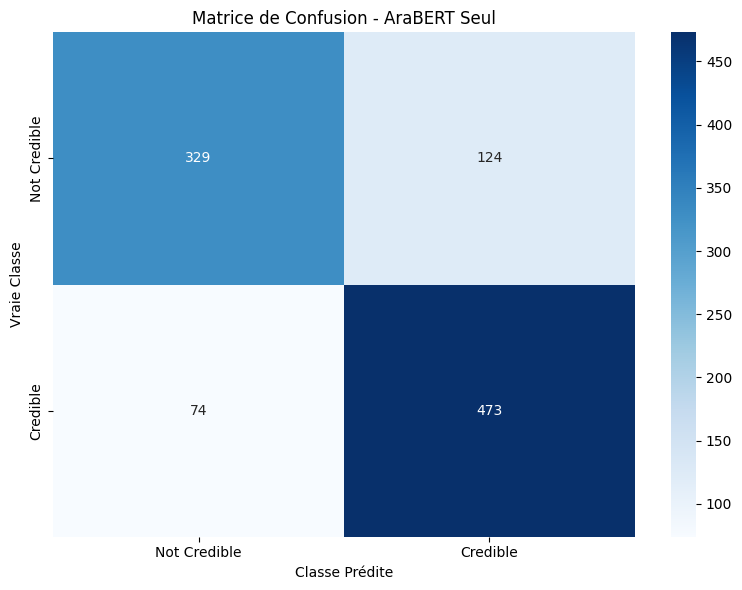

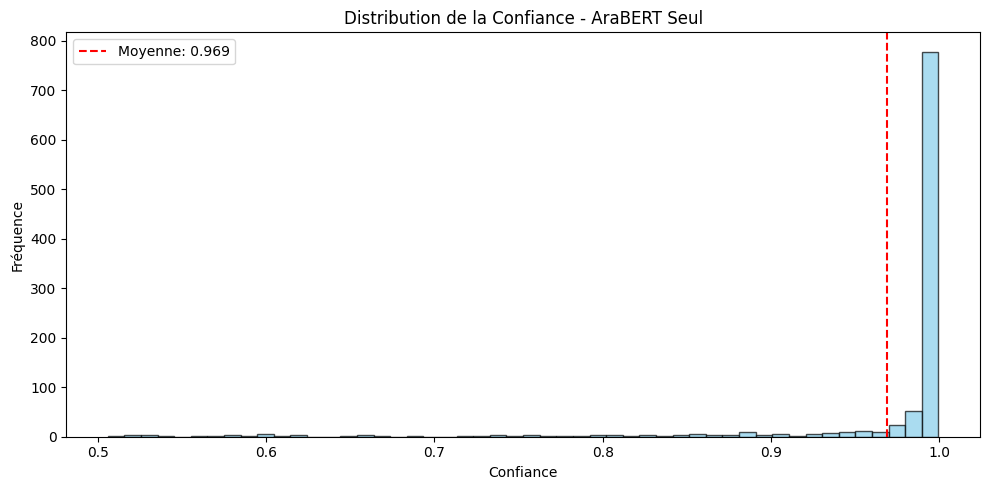


📊 Confiance moyenne: 0.969

🔧 Création du détecteur hybride...

📈 ÉVALUATION MODÈLE HYBRIDE
🔍 Génération des prédictions hybrides...

📊 RÉSULTATS MODÈLE HYBRIDE
Accuracy: 80.10%
Precision (Credible): 78.16%
Recall (Credible): 88.30%
F1-Score (Credible): 82.92%

🎯 Distribution de confiance:
  Haute confiance 🟢: 890 (89.0%)
  Faible confiance - Vérification recommandée 🔴: 32 (3.2%)
  Confiance moyenne 🟡: 78 (7.8%)


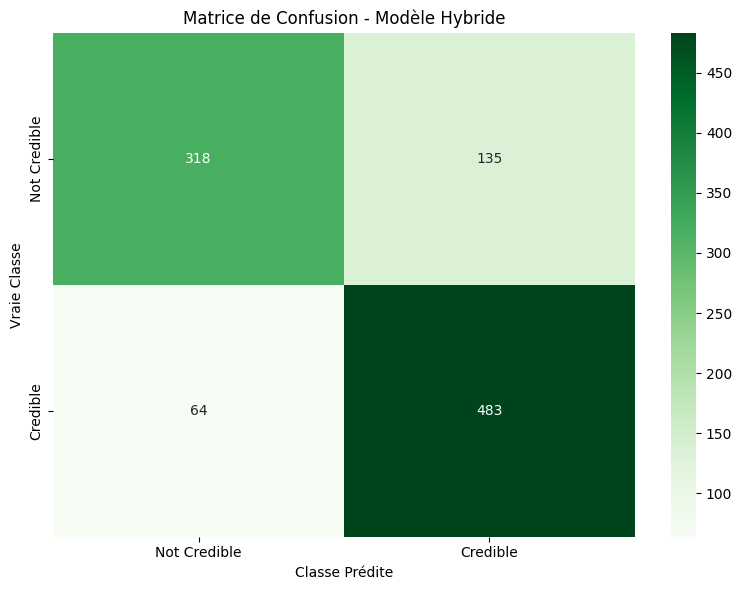


🔬 TESTS DÉTAILLÉS DU SYSTÈME HYBRIDE

📰 EXEMPLE 1:
Texte: عاجل: الحكومة تعلن عن إجراءات جديدة لمكافحة الفساد في القطاع العام...
--------------------------------------------------------------------------------
🎯 PRÉDICTION FINALE: Not Credible (Fake) ❌
📊 Score de crédibilité: 33.81%
🔒 Niveau de confiance: Haute confiance 🟢

💡 Recommandation: ⚠️ Article probablement non crédible

🤖 Analyse BERT:
  - Prédiction: Not Credible
  - Confiance: 98.48%
  - Score crédibilité: 1.52%

📝 Analyse Linguistique:
  - Score crédibilité: 82.25%
  - Niveau suspicion: Faible suspicion
  - Détails:
      • sensationalism: 0.85
      • vague_sources: 1.00
      • punctuation: 1.00
      • caps: 1.00
      • length: 0.50
      • credibility_markers: 0.65
      • numbers: 0.60

📰 EXEMPLE 2:
Texte: مصادر مطلعة: فضيحة كبرى في الوزارة!!! لن تصدق ما حدث...
--------------------------------------------------------------------------------
🎯 PRÉDICTION FINALE: Credible ✅
📊 Score de crédibilité: 84.48%
🔒 Niveau de con

In [ ]:
# EXÉCUTION
if __name__ == "__main__":
    print("📦 Installation des dépendances...")
    import subprocess
    subprocess.run(["pip", "install", "-q", "transformers", "datasets", "accelerate"], check=True)

    model, tokenizer, detector, df, X_train, X_test, y_train, y_test = main()

######################

In [ ]:


# 10. PRÉDICTION SUR UN TEXTE
def predict_news(text, model, tokenizer):
    """Prédit si un article est fake ou crédible"""
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()

    # Nettoyer le texte
    text_clean = preprocess_text(text)

    encoding = tokenizer(
        text_clean,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    ).to(device)

    with torch.no_grad():
        outputs = model(**encoding)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        pred = torch.argmax(probs, dim=1).item()
        conf = probs[0][pred].item()

    result = {
        'prediction': 'Credible ' if pred == 1 else 'Not Credible (Fake) ❌',
        'label': pred,
        'confidence': conf,
        'probabilities': {
            'Not Credible': probs[0][0].item(),
            'Credible': probs[0][1].item()
        }
    }

    return result

In [ ]:
# 11. FONCTION PRINCIPALE
def main():
    """Pipeline complet: du téléchargement à la prédiction"""
    print("="*60)
    print(" DÉTECTION DE FAKE NEWS EN ARABE AVEC ARABERT")
    print("="*60)

    # 1. Charger le dataset
    extract_path = mount_and_extract_dataset()
    all_articles = load_articles(extract_path)

    # 2. Préparer les données
    df = prepare_dataframe(all_articles, sample_size=5000)

    # 3. Split train/test
    X_train, X_test, y_train, y_test = split_data(df)

    # 4. Entraîner AraBERT
    model, tokenizer, trainer = train_arabert(X_train, y_train, X_test, y_test)

    # 5. Évaluation détaillée
    predictions, confidences = evaluate_model(model, tokenizer, X_test, y_test)

    # 6. Tests de prédiction
    print("\n" + "="*60)
    print(" TESTS DE PRÉDICTION")
    print("="*60)

    # Test 1: Article du test set
    exemple1 = X_test['content'].iloc[0]
    vrai_label1 = y_test.iloc[0]
    result1 = predict_news(exemple1, model, tokenizer)

    print(f"\n Article 1:")
    print(f"Texte: {exemple1[:100]}...")
    print(f"Vraie classe: {'Credible' if vrai_label1 == 1 else 'Not Credible'}")
    print(f"Prédiction: {result1['prediction']}")
    print(f"Confiance: {result1['confidence']:.2%}")

    # Test 2: Article personnalisé
    exemple2 = "الحكومة تعلن عن إجراءات جديدة لمكافحة الفساد في القطاع العام"
    result2 = predict_news(exemple2, model, tokenizer)

    print(f"\n Article 2 (personnalisé):")
    print(f"Texte: {exemple2}")
    print(f"Prédiction: {result2['prediction']}")
    print(f"Confiance: {result2['confidence']:.2%}")
    print(f"Probabilités:")
    print(f"  - Not Credible: {result2['probabilities']['Not Credible']:.2%}")
    print(f"  - Credible: {result2['probabilities']['Credible']:.2%}")

    print("\n" + "="*60)
    print(" PROCESSUS TERMINÉ")
    print("="*60)

    return model, tokenizer, df, X_train, X_test, y_train, y_test


 Installation des dépendances...
 DÉTECTION DE FAKE NEWS EN ARABE AVEC ARABERT
 Montage de Google Drive...
Mounted at /content/drive
 Extraction du fichier ZIP...
 Fichiers extraits avec succès.
 Chargement des articles...
 374543 articles chargés depuis 103 sources.

 Préparation du DataFrame...
 Nettoyage du texte...

 Distribution des labels:
label
1    2734
0    2266
Name: count, dtype: int64

Nombre total d'articles: 5000

✂️ Division train/test...
Train: 4000 articles
Test: 1000 articles

 ENTRAÎNEMENT ARABERT
 Chargement du modèle: aubmindlab/bert-base-arabertv2


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Device: cuda

 Début de l'entraînement...



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.533900,0.580546,0.700000,0.656751,0.877676,0.524680
2,0.392500,0.559980,0.789000,0.818884,0.771845,0.872029
3,0.399100,0.667547,0.784000,0.819095,0.755796,0.893967
4,0.233800,0.906111,0.802000,0.827526,0.790349,0.868373



 Évaluation finale...



RÉSULTATS FINAUX
eval_loss: 0.9061
eval_accuracy: 0.8020
eval_f1: 0.8275
eval_precision: 0.7903
eval_recall: 0.8684
eval_runtime: 8.6310
eval_samples_per_second: 115.8610
eval_steps_per_second: 7.2990
epoch: 4.0000

 Modèle sauvegardé dans: ./arabert_fakenews_model

 ÉVALUATION DÉTAILLÉE
 Génération des prédictions...

 Rapport de Classification:
                     precision    recall  f1-score   support

Not Credible (Fake)       0.82      0.72      0.77       453
           Credible       0.79      0.87      0.83       547

           accuracy                           0.80      1000
          macro avg       0.80      0.80      0.80      1000
       weighted avg       0.80      0.80      0.80      1000



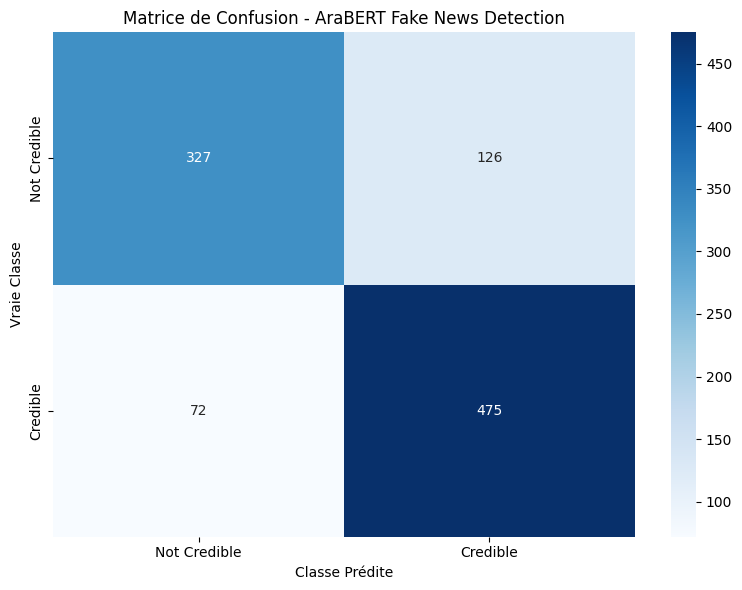

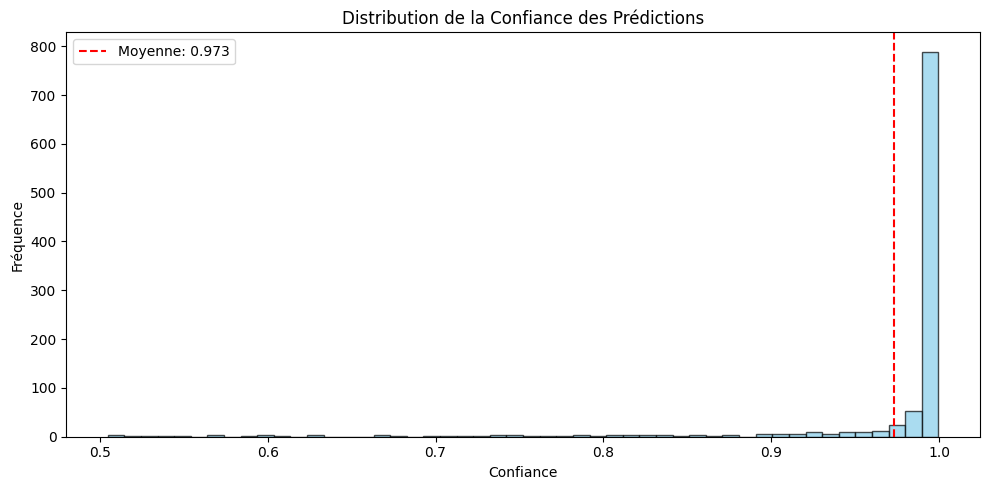


 Confiance moyenne: 0.973

 TESTS DE PRÉDICTION

 Article 1:
Texte: اعتقال مسوولين اردنيين بارزين لاسباب امنيه 

قال مصدر امني اردني، اليوم السبت، انه وبعد متابعه امنيه...
Vraie classe: Credible
Prédiction: Not Credible (Fake) ❌
Confiance: 99.89%

 Article 2 (personnalisé):
Texte: الحكومة تعلن عن إجراءات جديدة لمكافحة الفساد في القطاع العام
Prédiction: Not Credible (Fake) ❌
Confiance: 96.54%
Probabilités:
  - Not Credible: 96.54%
  - Credible: 3.46%

 PROCESSUS TERMINÉ


In [ ]:

# EXÉCUTION

if __name__ == "__main__":
    # Installer les dépendances
    print(" Installation des dépendances...")
    import subprocess
    subprocess.run(["pip", "install", "-q", "transformers", "datasets", "accelerate"], check=True)

    # Lancer le pipeline complet
    model, tokenizer, df, X_train, X_test, y_train, y_test = main()

In [ ]:
!pip install transformers datasets accelerate
